In [36]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from functorch.dim import softmax

from monai.config import print_config
from monai.transforms import LoadImage, SpatialCrop, SpatialCropd
import monai

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /cluster/work/<username>/medical-image-segmentation/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 11.0.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu124
tqdm version: 4.67.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.1.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

image data shape: torch.Size([1, 512, 512, 75])
meta data: dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj'])


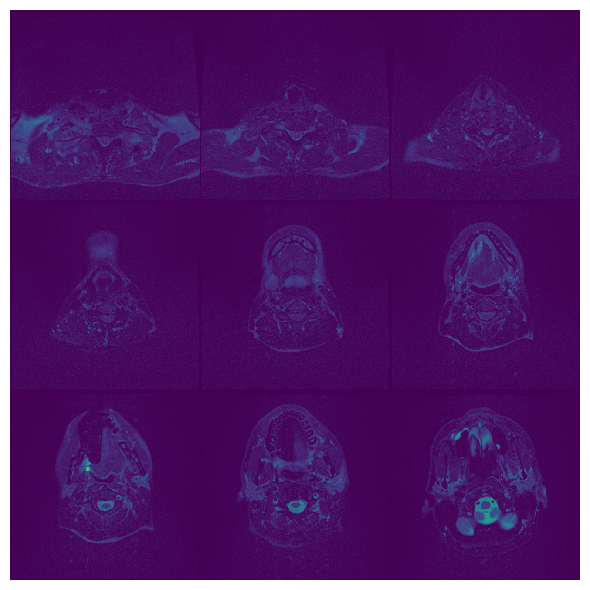

In [37]:
filename = "data/test/29/preRT/29_preRT_T2.nii.gz"
filename_mask = "data/test/29/preRT/29_preRT_mask.nii.gz"

data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename)
mask = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename_mask)
print(f"image data shape: {data.shape}")
print(f"meta data: {data.meta.keys()}")
mask = mask > 0

masked_data = data + mask * 255

monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(masked_data), every_n=9, figsize=(6, 6))
plt.show()


In [44]:
from data import create_dataset_dicts
from monai.data import Dataset
from monai.transforms import (
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    Compose,
    Resized,
    Spacingd,
    ToTensord,
    SpatialPadd,
    SpatialCropd,
    ToDeviced,
    SelectItemsd,
    NormalizeIntensityd,
    AsDiscreted,
    RandSpatialCropd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    MapTransform,
    AsDiscreted,
    Activations,
    AsDiscrete,
    Orientationd,
)

class ConvertLabelIdToChannel(MapTransform):
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

device = "cuda"
data_dicts = create_dataset_dicts("data/train")
train_transforms = Compose(
    [
        # Load data
        LoadImaged(keys=["image", "mask"]),
        SelectItemsd(keys=["image", "mask"]),
        ConvertLabelIdToChannel(keys="mask"),
        EnsureChannelFirstd(keys=["image"]),

        # Normalization and cropping
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(
            keys=["image", "mask"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "mask"], roi_size=[256, 256, 96], random_size=False),
        # SpatialCropd(keys=["image", "mask"], roi_center=[256,256,40], roi_size=[196, 196, 80]),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=2),

        NormalizeIntensityd(keys="image", nonzero=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),


        # Ensure correct size
        Resized(
            keys=["image", "mask"],
            spatial_size=(256, 256, 96),
            mode=("bilinear", "nearest"),
        ),
    ]
)

dataset = Dataset(data_dicts, train_transforms)
idx=4
dataset[idx]['image'].shape, dataset[idx]['mask'].shape

(torch.Size([1, 256, 256, 96]), torch.Size([2, 256, 256, 96]))

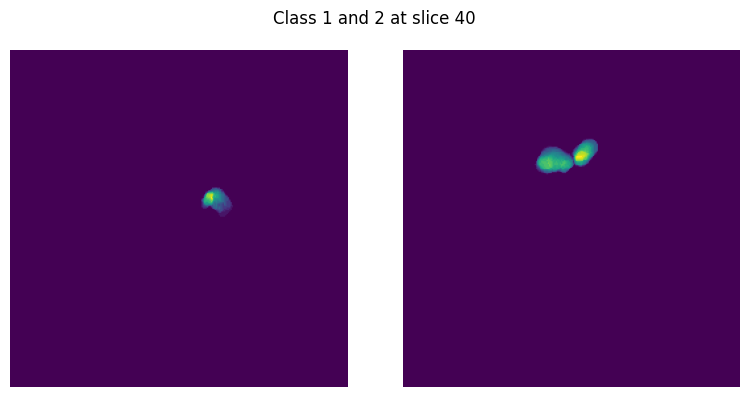

In [46]:
# Visualization of two classes at slice 40
idx=2
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
[a.axis('off') for a in ax]
ax[0].imshow(dataset[idx]['mask'][0, :, :, :].sum(-1).cpu())
ax[1].imshow(dataset[idx]['mask'][1, :, :, :].sum(-1).cpu())
fig.suptitle("Class 1 and 2 at slice 40")
fig.tight_layout();

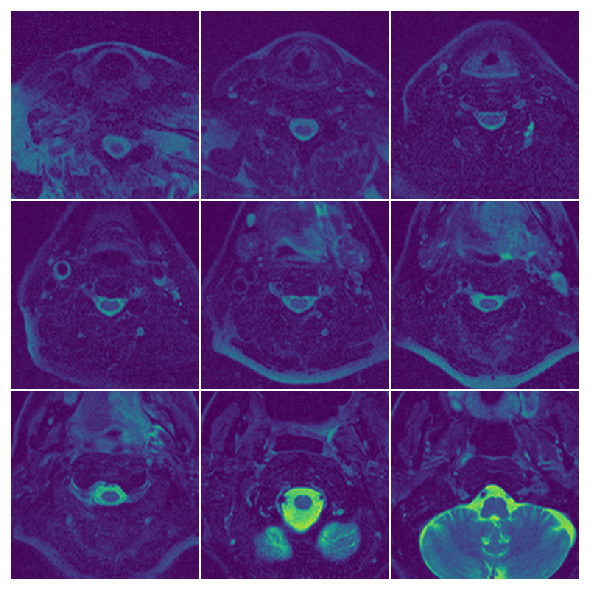

In [ ]:
test_transforms = Compose(
    [
        # Load data
        LoadImaged(keys=["image", "mask"]),
        SelectItemsd(keys=["image", "mask"]),
        ConvertLabelIdToChannel(keys="mask"),
        EnsureChannelFirstd(keys=["image"]),

        # Normalization and resizing
        SpatialCropd(keys=["image", "mask"], roi_center=[256,256,40], roi_size=[256, 256, 96]),
        NormalizeIntensityd(keys="image"),
        Resized(keys=["image", "mask"], spatial_size=(256, 256, 96), mode=("bilinear", "nearest")),
        ToDeviced(keys=["image", "mask"], device=device),
    ]
)
data_dicts_test = create_dataset_dicts("data/test")
test_dataset = Dataset(data_dicts_test, test_transforms)
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(test_dataset[0]['image']), every_n=11, figsize=(6, 6))
plt.show()

In [ ]:
# model = monai.networks.nets.UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=2,
#     channels=(64, 128, 256, 256),
#     strides=(2, 2, 2),
#     num_res_units=2,
# ).to(device)
# model = monai.networks.nets.SegResNet(
#     blocks_down=[1, 2, 2, 4],
#     blocks_up=[1, 1, 1],
#     init_filters=16,
#     in_channels=1,
#     out_channels=2,
#     dropout_prob=0.2,
# ).to(device)
model = monai.networks.nets.SwinUNETR(
    in_channels=1,
    out_channels=2,
    img_size=(256,256,96),
    spatial_dims=3,
    use_checkpoint=False,
    use_v2=True,
).to(device)

/cluster/work/andrebw/medical-image-segmentation/venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [ ]:
from monai.data import DataLoader
from tqdm import tqdm
from monai.data import create_test_image_3d, list_data_collate, pad_list_data_collate

batch_size = 1

loader = DataLoader(dataset, batch_size=batch_size)
e = 0
losses = []

In [ ]:
# Training loop
import monai.optimizers
import time

epochs = 50
optimizer = torch.optim.Adam(model.parameters(), 2e-3)

loss_function = monai.losses.DiceLoss(
    smooth_nr=0,
    smooth_dr=1e-5,
    squared_pred=True,
    to_onehot_y=False, # False
    sigmoid=True,
    # weight=torch.tensor([1.1886071e+00, 8.6305177e-01]).to(device)
)

# loss_function = monai.losses.DiceCELoss(
#     include_background=False, 
#     to_onehot_y=True,
#     weight=torch.tensor([0, 1.1886071e+00, 8.6305177e-01]).to(device)
#     # weight=torch.tensor([3.3394375e-01, 4.3348691e+02, 3.1475632e+02]).to(device)
# )
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
for e in range(e, epochs + e):
    print(f"Epoch: {e}")
    time.sleep(0.1)
    model.train()
    for batch in tqdm(loader, desc="Training step"):
        inputs, labels = batch['image'].to(device), batch['mask'].to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    lr_scheduler.step(e)
    print(f"Loss: {np.mean(losses[-130:])}")
e += 1

Epoch: 5


Training step: 100%|██████████| 130/130 [03:05<00:00,  1.42s/it]


Loss: 0.9537766268620125
Epoch: 6


Training step: 100%|██████████| 130/130 [03:06<00:00,  1.43s/it]


Loss: 0.934868212388112
Epoch: 7


Training step: 100%|██████████| 130/130 [03:04<00:00,  1.42s/it]


Loss: 0.8964330521913675
Epoch: 8


Training step: 100%|██████████| 130/130 [03:04<00:00,  1.42s/it]


Loss: 0.8669809295580937
Epoch: 9


Training step: 100%|██████████| 130/130 [03:15<00:00,  1.50s/it]


Loss: 0.8480407545199761
Epoch: 10


Training step: 100%|██████████| 130/130 [03:06<00:00,  1.43s/it]


Loss: 0.8419264802565941
Epoch: 11


Training step:   2%|▏         | 2/130 [00:03<03:16,  1.54s/it]


KeyboardInterrupt: 

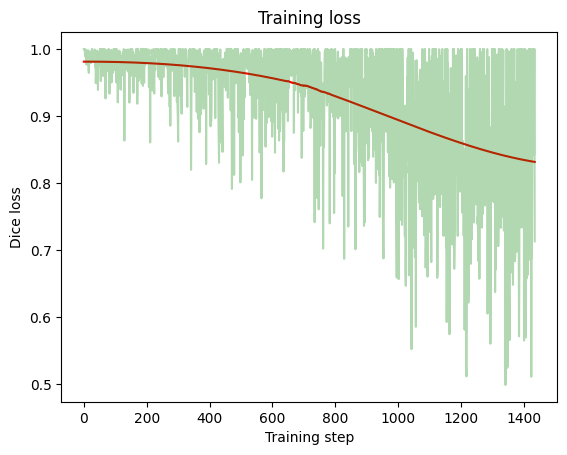

In [ ]:
from scipy.signal import savgol_filter

plt.plot(savgol_filter(losses, int(len(losses)*0.90), 3), color="red", alpha=1.0)
plt.plot(losses, color="green", alpha=0.3)
plt.title("Training loss")
plt.xlabel("Training step")
plt.ylabel("Dice loss");

In [ ]:
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

(torch.Size([256, 256, 3]), torch.Size([256, 256, 3]))

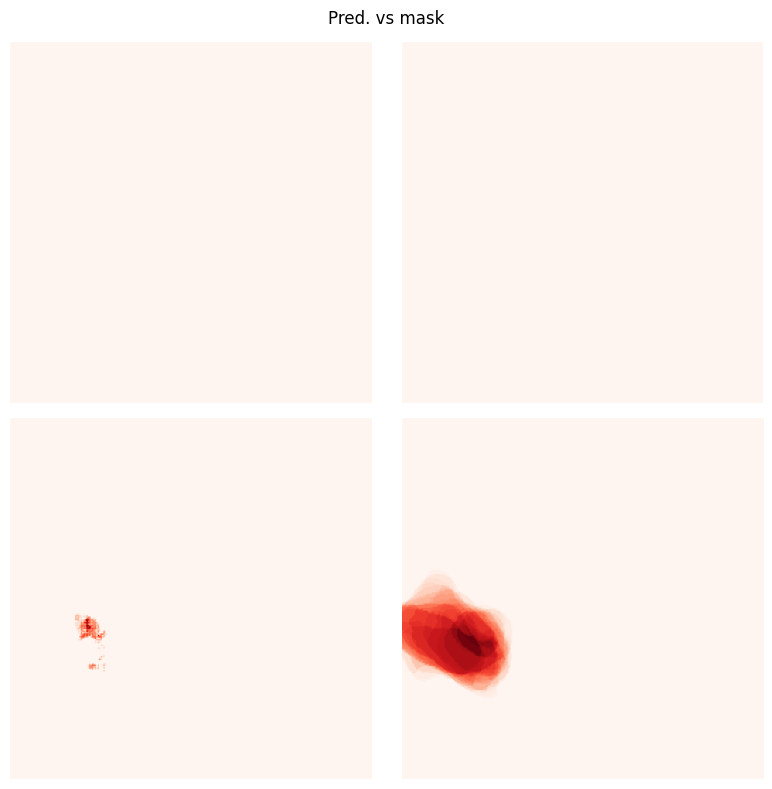

In [ ]:
idx = 0
pred = post_trans(model(test_dataset[idx]['image'].unsqueeze(0))).cpu()
pred = torch.stack([torch.zeros(pred.shape[2:]), pred[0,0], pred[0,1]], axis=0)[:,:,:,:].sum(-1).transpose(0,2).transpose(0,1)
mask = test_dataset[idx]['mask'].cpu()
mask = torch.stack([torch.zeros(mask.shape[1:]), mask[0], mask[1]], axis=0)[:,:,:,:].sum(-1).transpose(0,2).transpose(0,1)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
[[a.axis('off') for a in ax] for ax in axs]
for row in range(len(axs)):
    axs[row][0].imshow(pred[:,:,row], cmap='Reds')
    axs[row][1].imshow(mask[:,:,row], cmap='Reds')
fig.suptitle("Pred. vs mask")
fig.tight_layout();
pred.shape, mask.shape

In [ ]:
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=True, reduction="mean_batch")

test_loader = DataLoader(test_dataset, batch_size=1)
for batch in tqdm(test_loader, desc="Testing steps"):
    inputs, labels = batch['image'], batch['mask']

    logits = model(inputs)
    preds = post_trans(logits)

    dice_metric(y_pred=preds, y=labels)

dice_score = dice_metric.aggregate()
print(f"Dice score 0: {dice_score[0]:.3f}")
print(f"Dice score 1: {dice_score[1]:.3f}")
dice_metric.reset()

Testing steps: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Dice score 0: 0.419
Dice score 1: 0.419


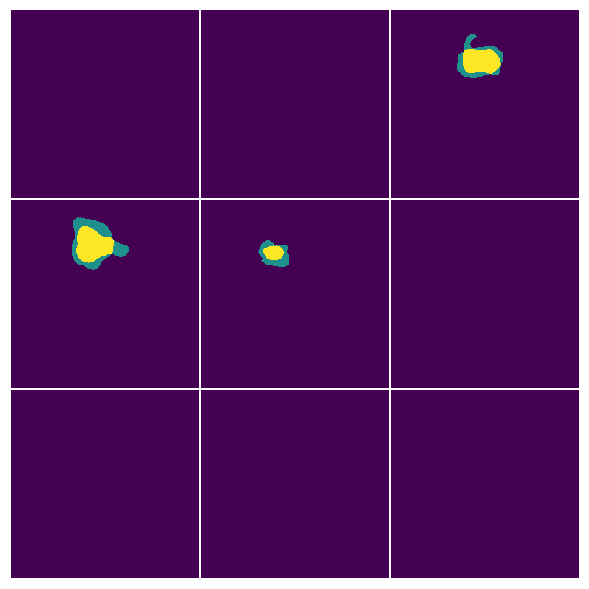

In [ ]:
sample = test_dataset[15]
mask = sample['mask'].unsqueeze(0)
pred = model(sample['image'].unsqueeze(0))
pred = post_trans(pred)
pred.shape, mask.shape
monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(pred[:,0]+mask[:,0]), every_n=9, figsize=(6, 6))
# monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(mask[:,0]), every_n=9, figsize=(6, 6));
1==1;